In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns
from IPython.display import Image, display
from scipy.optimize import minimize
%config InlineBackend.figure_format = 'retina'

# Read in historical data

In [88]:
df = pd.read_csv('../data_in/ETFs.csv')
cols = ["date","AGG","SPY", "GLD"]
df = df[cols]
df = df.rename(columns={"AGG":"Bond","GLD":"Commodity","SPY":"Equity","date":"date"})
df['date'] = pd.to_datetime(df['date'], format="%Y%m%d")
df = df.dropna()
df.set_index('date', inplace=True)
df = df.unstack().to_frame("price").reset_index().rename(columns={"level_0":"asset_id"})

ret = (df.pivot_table(index='date', values='price', columns='asset_id')
       .pct_change().unstack()
       .to_frame('return').reset_index())

df = df.merge(ret, on=['date', 'asset_id'], how='left')

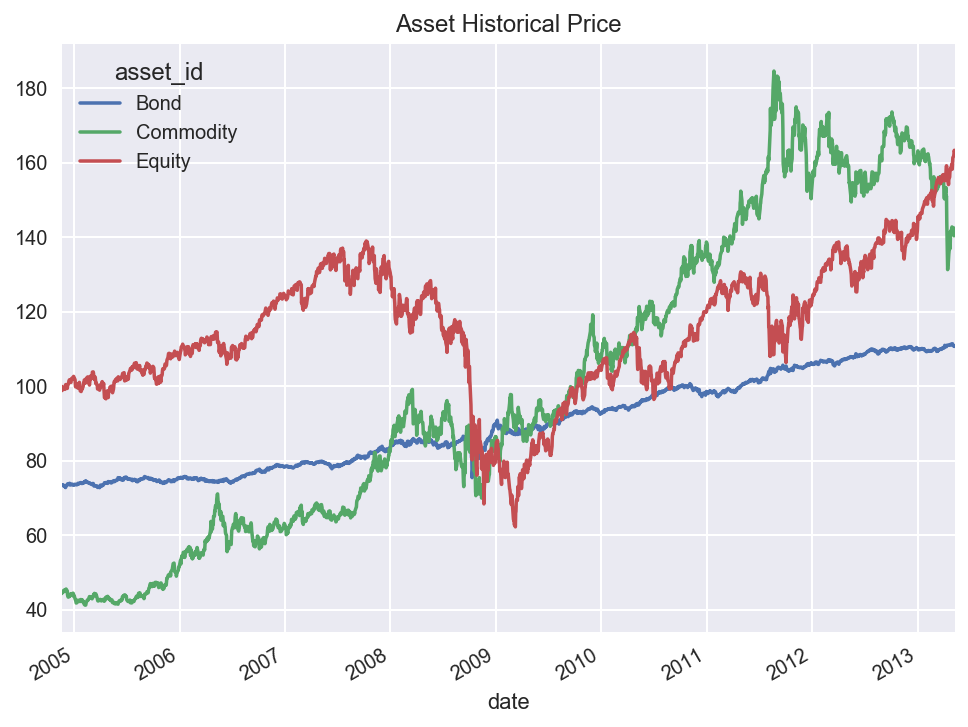

In [89]:
df.pivot_table(index='date', values='price', columns='asset_id')\
    .plot(figsize=(8, 6), title='Asset Historical Price');

### correlation matrix of percentage return between assets

In [90]:
df.pivot_table(index='date', values='return', columns='asset_id').corr().round(2)

asset_id,Bond,Commodity,Equity
asset_id,,,
Bond,1.00,0.08,-0.10
Commodity,0.08,1.00,0.07
Equity,-0.10,0.07,1.00


# Simple Risk Parity

* Assume no correlation among assets, so that weight of asset is 1/(asset_volatility)

Use **half-life** to compute asset volatility

In [91]:
volatility = (df.pivot_table(values='return', index='date', columns='asset_id')
                      .rolling(window=60).std()*np.sqrt(252))
vol = volatility.unstack().to_frame('vol').reset_index()

df = df.merge(vol, on=['date', 'asset_id'], how='left')


In [92]:
df['weights'] = 1/df['vol']
df['weights'] = df[['asset_id','date','weights']].groupby('date')['weights'].transform(lambda x: x/x.sum())

In [93]:
portf_return = (df
                .groupby("date")
                .apply(lambda x: (x["weights"] * x["return"]).sum())
                .to_frame("port_ret"))

In [94]:
def get_summary(df_return):
    # average annual return
    ann_return = df_return.mean()*252
    # volatility of all assets&portfolios
    ann_vol = df_return.std()*np.sqrt(252)
    sharpe = ann_return/ann_vol
    summary = pd.DataFrame({"ann_return (%)":ann_return*1e2, 
                            "ann_vol (%)":ann_vol*1e2,
                            "sharpe":sharpe}).round(2)
    return summary

In [95]:
summary = get_summary(portf_return)

In [96]:
summary

,ann_return (%),ann_vol (%),sharpe
port_ret,6.99,6.11,1.14


### Calculate weight contribution

In [97]:
weights = df.pivot_table(values='weights', index='date', columns='asset_id')
pct_return = df.pivot_table(values='return', index='date', columns='asset_id')

assert len(weights) == len(pct_return), "dimension mismatch between weights and return!"

pct_risk_contrib = weights*0

for i in range(len(weights)):
    if i >= 60:
        weights_vect = weights.iloc[i]
        Sigma = pct_return.iloc[i-60:i,:].cov()
        var_p = weights_vect.dot(Sigma).dot(weights_vect)
        risk_contribution_vect = (weights_vect*(Sigma.dot(weights_vect)))/var_p
        pct_risk_contrib.iloc[i,:] = np.array(risk_contribution_vect)
        

In [98]:
pct_risk_contrib.mean()

asset_id
Bond         0.277094
Commodity    0.423407
Equity       0.299499
dtype: float64

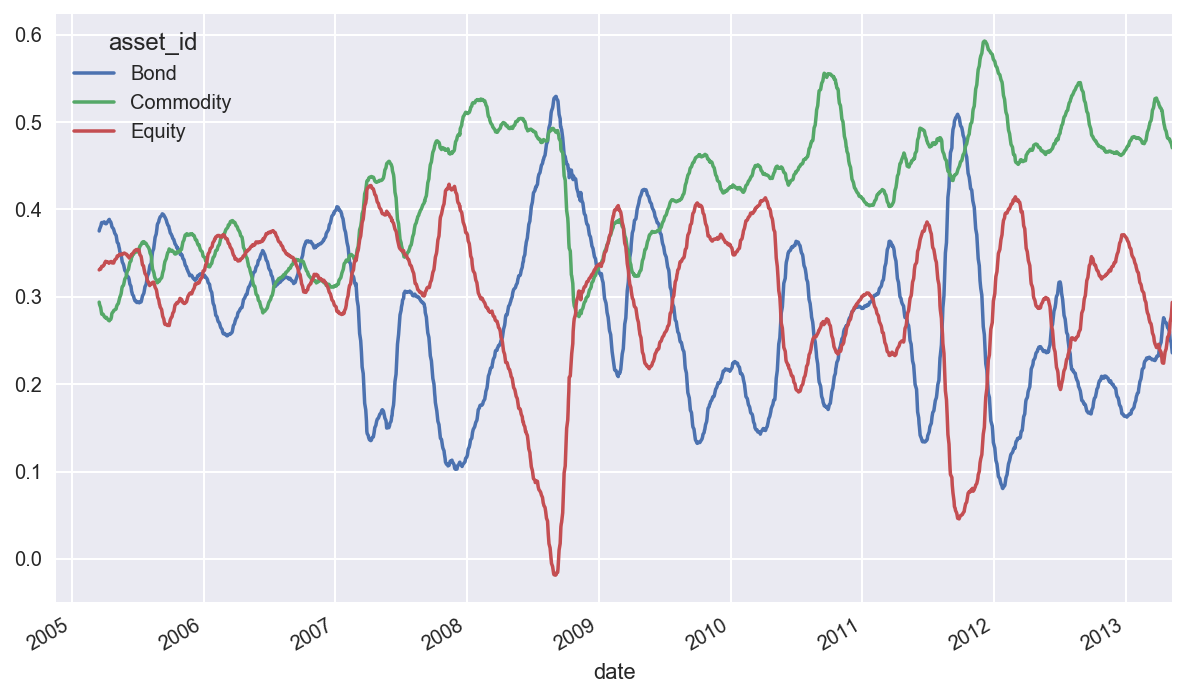

In [99]:
pct_risk_contrib.rolling(window=22).mean().plot(figsize=(10,6))

In [76]:
prior = np.array([0.3,0.4,0.3])
actual = np.array([0.8, 0.1, 0.1])

factor = 1

actual + (prior-actual) * factor

array([0.3, 0.4, 0.3])

In [106]:
tickers = ["SPY", "AGG", "GLD"]
weights_prior = np.array([1 / len(tickers)] * 3) 

weights_prior

array([0.33333333, 0.33333333, 0.33333333])